Convolusional Neural Network

In [29]:
from google.colab import drive
import os
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


Menyiapkan Direktori

In [30]:
base_dir = '/content/drive/MyDrive/Asian vs African elephants'
!ls "/content/drive/MyDrive/Asian vs African elephants"

bahan  latih  validasi


In [31]:
# menentukan direktori

bahan_dir = os.path.join(base_dir, 'bahan')
train_dir = os.path.join(base_dir, 'latih')
validation_dir = os.path.join(base_dir, 'validasi')

In [33]:
#  menentukan direktori isi bahan
african_dir = os.path.join(bahan_dir, 'African/')
asian_dir = os.path.join(bahan_dir, 'Asian/')

print("Jumlah Data Elephants")
print('total african images:', len(os.listdir(african_dir)))
print('total asian images:', len(os.listdir(asian_dir)))

Jumlah Data Elephants
total african images: 112
total asian images: 112


In [34]:
# Direktori isi latih/training
train_african = os.path.join(train_dir, 'african/')
train_asian = os.path.join(train_dir, 'asian/')

# direktori isi validasi
validation_african = os.path.join(validation_dir, 'african/')
validation_asian = os.path.join(validation_dir, 'asian/')

Menyiapkan dataset

In [35]:
import os
import random
from shutil import copyfile

def train_val_split(source, train, val, train_ratio):
    if not os.path.exists(source):
        print(f"Error: Folder sumber tidak ditemukan -> {source}")
        return
    if not os.path.exists(train):
        os.makedirs(train)  # Buat folder jika belum ada
    if not os.path.exists(val):
        os.makedirs(val)  # Buat folder jika belum ada

    total_files = os.listdir(source)
    total_size = len(total_files)

    if total_size == 0:
        print(f"Error: Folder sumber kosong -> {source}")
        return

    train_size = int(total_size * train_ratio)
    val_size = total_size - train_size

    randomized = random.sample(total_files, total_size)
    train_files = randomized[:train_size]
    val_files = randomized[train_size:]

    for i in train_files:
        i_file = os.path.join(source, i)
        destination = os.path.join(train, i)
        if os.path.exists(i_file):  # Cek apakah file benar-benar ada
            copyfile(i_file, destination)
        else:
            print(f"File tidak ditemukan: {i_file}")

    for i in val_files:
        i_file = os.path.join(source, i)
        destination = os.path.join(val, i)
        if os.path.exists(i_file):
            copyfile(i_file, destination)
        else:
            print(f"File tidak ditemukan: {i_file}")

train_ratio = 0.9

# Cek apakah variabel path sudah didefinisikan sebelumnya
try:
    source_00 = african_dir
    train_00 = train_african
    val_00 = validation_african
    train_val_split(source_00, train_00, val_00, train_ratio)

    source_01 = asian_dir
    train_01 = train_asian
    val_01 = validation_asian
    train_val_split(source_01, train_01, val_01, train_ratio)

except NameError as e:
    print(f"Error: Variabel tidak didefinisikan - {e}")


In [36]:
print('Jumlah data latih asian:', len(os.listdir(asian_dir)))
print('Jumlah data latih asian:', len(os.listdir(train_asian)))
print('jumlah val asian :', len(os.listdir(validation_asian)))

Jumlah data latih asian: 112
Jumlah data latih asian: 112
jumlah val asian : 24


pre procesing

In [37]:
import tensorflow as tf
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [38]:
import tensorflow as tf
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(
                    rescale=1./255,
                    rotation_range=30,
                    horizontal_flip=True,
                    shear_range = 0.3,
                    fill_mode = 'nearest',
                    width_shift_range = 0.2,
                    height_shift_range=0.2,
                    zoom_range = 0.1
)

validation_datagen = ImageDataGenerator(
                    rescale=1./255,
                    rotation_range=30,
                    horizontal_flip=True,
                    shear_range = 0.3,
                    fill_mode = 'nearest',
                    width_shift_range = 0.2,
                    height_shift_range=0.2,
                    zoom_range = 0.1
                    )

target

In [39]:
train_generator = train_datagen.flow_from_directory(
        train_dir,
        target_size=(150, 150),
        batch_size=32,
        class_mode='categorical'
)

val_generator = validation_datagen.flow_from_directory(
        validation_dir,
        target_size=(150, 150),
        batch_size=32,
        class_mode='categorical'
)

Found 223 images belonging to 2 classes.
Found 47 images belonging to 2 classes.


In [40]:
class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('accuracy')>0.99):
      print("\nAkurasi mencapai 99%")
      self.model.stop_training = True
callbacks = myCallback()

model cnn

In [41]:
model = tf.keras.models.Sequential ([

    tf.keras.layers.Conv2D(32, (3,3), activation='relu', input_shape=(150, 150, 3)),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(32, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(32, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(200, activation='relu'),
    tf.keras.layers.Dropout(0.3, seed =112),
    tf.keras.layers.Dense(500, activation='relu'),
    tf.keras.layers.Dropout(0.5, seed=112),
    tf.keras.layers.Dense(2, activation='sigmoid')

])


In [42]:
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)                    │ (None, 148, 148, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 74, 74, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 72, 72, 32)          │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 36, 36, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 34, 34, 32)          │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ (None, 17, 17, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 9248)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 200)                 │       1,849,800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 200)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 500)                 │         100,500 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 500)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 2)                   │           1,002 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,970,694 (7.52 MB)

 Trainable params: 1,970,694 (7.52 MB)

 Non-trainable params: 0 (0.00 B)

In [43]:
model.compile(
    loss='categorical_crossentropy',
    optimizer= 'Adam',
    metrics=['accuracy']
)

In [44]:
history = model.fit(
    train_generator,
    steps_per_epoch=6,
    epochs=25,
    validation_data=val_generator,
    validation_steps=1,
    verbose=1,
    callbacks=[callbacks]
)

Epoch 1/25
6/6 ━━━━━━━━━━━━━━━━━━━━ 8s 1s/step - accuracy: 0.4735 - loss: 0.7338 - val_accuracy: 0.5312 - val_loss: 0.6924
Epoch 2/25
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 86ms/step - accuracy: 0.6250 - loss: 0.6712 - val_accuracy: 0.5312 - val_loss: 0.6850
Epoch 3/25
6/6 ━━━━━━━━━━━━━━━━━━━━ 5s 834ms/step - accuracy: 0.4955 - loss: 0.7073 - val_accuracy: 0.4688 - val_loss: 0.6928
Epoch 4/25
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 159ms/step - accuracy: 0.4062 - loss: 0.7068 - val_accuracy: 0.5000 - val_loss: 0.6921
Epoch 5/25
6/6 ━━━━━━━━━━━━━━━━━━━━ 8s 709ms/step - accuracy: 0.5049 - loss: 0.6915 - val_accuracy: 0.5000 - val_loss: 0.6938
Epoch 6/25
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 94ms/step - accuracy: 0.5938 - loss: 0.6920 - val_accuracy: 0.4688 - val_loss: 0.6941
Epoch 7/25
6/6 ━━━━━━━━━━━━━━━━━━━━ 10s 877ms/step - accuracy: 0.5696 - loss: 0.6915 - val_accuracy: 0.6250 - val_loss: 0.6861
Epoch 8/25
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 167ms/step - accuracy: 0.5312 - loss: 0.6849 - val_accuracy: 0.4688 - val_loss: 0.6

Tingkat akurasi dan loss model

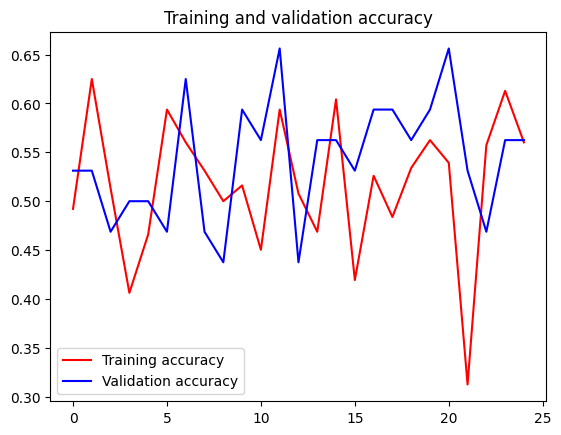

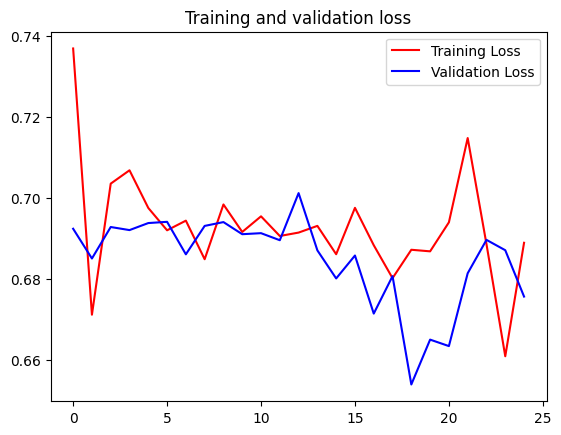

In [45]:
%matplotlib inline
import matplotlib.image as mpimg
import matplotlib.pyplot as plt

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc='best')
plt.show()

plt.plot(epochs, loss, 'r', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and validation loss')
plt.legend(loc='best')
plt.show()

Saving af_tr262.jpg to af_tr262.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
af_tr262.jpg
This image belongs to class african


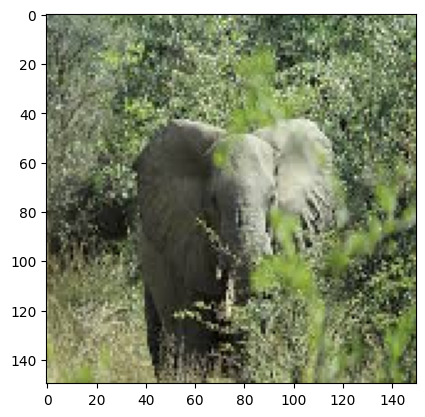

In [96]:
import numpy as np
from keras.preprocessing import image
from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():

  # predicting images
  path = fn
  img = image.load_img(path, target_size=(150,150))
  imgplot = plt.imshow(img)
  x = image.img_to_array(img)
  x = np.expand_dims(x, axis=0)

  images = np.vstack([x])
  classes = model.predict(images, batch_size=10)

  print(fn)
  class_list = os.listdir(train_dir)

  predicted_class_index = np.argmax(classes[0])
  print('This image belongs to class', class_list[predicted_class_index]) # Use predicted_class_index instead of j